#    " Customer Churn Prediction Using Bagging-Based Ensemble Methods"

## Abstract:  

*Introduction*  
This project focuses on predicting customer churn using ensemble models like Random Forest and Extra Trees. These models use bagging to combine multiple decision trees, reducing overfitting and improving accuracy. The goal is to build a reliable churn prediction model and understand which features influence customer exit behavior.

*Why Ensemble Learning?*  
Ensemble models improve prediction by averaging results from many decision trees. They handle noise better and offer stronger performance compared to a single tree.

*Dataset Overview*  
We use a telecom churn dataset with features like customer demographics, account details, and service usage. The target variable is `Exited` (1 = churned, 0 = stayed).

*Methodology*  
- *Preprocessing:* One-hot encode categorical features and split data using stratified sampling.  
- *Modeling:* Train Random Forest and Extra Trees using different tree counts. Use Out-of-Bag (OOB) error to track model performance.  
- *Evaluation:* Measure accuracy, precision, recall, F1, and AUC. Compare models and analyze feature importance.


In [2]:
from google.colab import files
uploaded = files.upload()

NameError: name 'files' is not defined

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import (classification_report,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score)
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

---

## Part 1: Setup
*Objective:* Load and explore the dataset.

*Steps & Explanation:*
- *Library Imports:* You import essential libraries for data manipulation (pandas, numpy), visualization (matplotlib, seaborn), and machine learning (sklearn).
- *Load Data:* The dataset Churn_Modelling.csv is loaded using pd.read_csv().
- *Initial Exploration:*
  - head() shows the first few rows to understand structure.
  - describe().T summarizes statistics like mean, std, min, max for each column.
  - dtypes helps identify which columns are numeric, categorical, or identifiers.
- *Correlation Heatmap:* A heatmap of numeric columns shows feature-to-feature relationships, useful for spotting multicollinearity.

---

In [ ]:
data=pd.read_csv('Churn_Modelling.csv')

In [ ]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
round(data.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5000.50,2886.90,1.00,2500.75,5000.50,7500.25,10000.00
CustomerId,10000.0,15690940.57,71936.19,15565701.00,15628528.25,15690738.00,15753233.75,15815690.00
CreditScore,10000.0,650.53,96.65,350.00,584.00,652.00,718.00,850.00
Age,10000.0,38.92,10.49,18.00,32.00,37.00,44.00,92.00
Tenure,10000.0,5.01,2.89,0.00,3.00,5.00,7.00,10.00
Balance,10000.0,76485.89,62397.41,0.00,0.00,97198.54,127644.24,250898.09
NumOfProducts,10000.0,1.53,0.58,1.00,1.00,1.00,2.00,4.00
HasCrCard,10000.0,0.71,0.46,0.00,0.00,1.00,1.00,1.00
IsActiveMember,10000.0,0.52,0.50,0.00,0.00,1.00,1.00,1.00
EstimatedSalary,10000.0,100090.24,57510.49,11.58,51002.11,100193.92,149388.25,199992.48


In [ ]:
data.dtypes

,0
RowNumber,int64
CustomerId,int64
Surname,object
CreditScore,int64
Geography,object
Gender,object
Age,int64
Tenure,int64
Balance,float64
NumOfProducts,int64


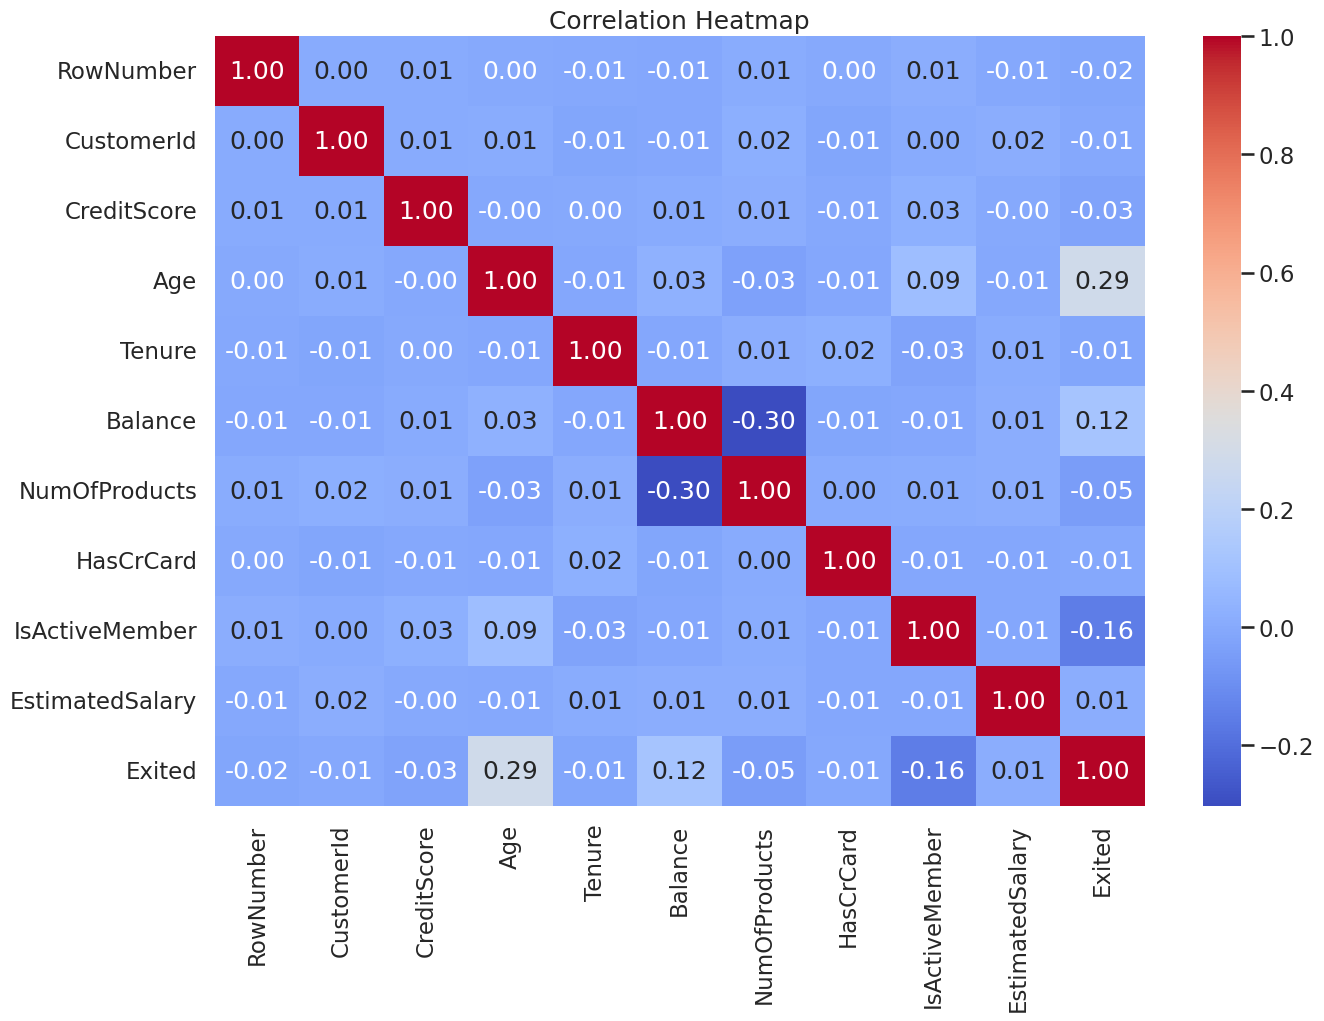

In [ ]:
# Plot correlation heatmap only for numeric columns
plt.figure(figsize=(15, 10))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

---

## Part 2: Target & Preprocessing
*Objective:* Define target variable and split the data.

*Steps & Explanation:*
- *Target Selection:* The binary variable Exited is chosen as the target indicating churn (1 = churned, 0 = stayed).
- *Class Imbalance Check:* The distribution of churn is imbalanced (e.g., 80% stayed, 20% churned).
- *Feature Selection:* Irrelevant columns like RowNumber, CustomerId, and Surname are dropped.
- *Train-Test Split:*
  - StratifiedShuffleSplit ensures class balance is maintained in both train and test sets.
  - 1500 samples are kept for testing to evaluate model performance.

---

In [ ]:
# Define target variable
target = 'Exited'

# Distribution of churn values
data[target].value_counts()
data[target].value_counts(normalize=True)

,proportion
Exited,
0,0.7963
1,0.2037


In [ ]:

# Define features: drop identifiers and target
feature_cols = [col for col in data.columns if col not in ['RowNumber', 'CustomerId', 'Surname', target]]

# Stratified shuffle split
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=1500, random_state=42)

# Get train/test indexes
for train_idx, test_idx in strat_split.split(data[feature_cols], data[target]):
    X_train = data.loc[train_idx, feature_cols]
    y_train = data.loc[train_idx, target]
    X_test = data.loc[test_idx, feature_cols]
    y_test = data.loc[test_idx, target]

In [ ]:
print("Train Distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest Distribution:")
print(y_test.value_counts(normalize=True))

Train Distribution:
Exited
0    0.796353
1    0.203647
Name: proportion, dtype: float64

Test Distribution:
Exited
0    0.796
1    0.204
Name: proportion, dtype: float64


---

## Part 3: Random Forest and OOB Error
*Objective:* Train a Random Forest model and measure Out-of-Bag (OOB) error.

*Steps & Explanation:*
- *RandomForestClassifier* is initialized with:
  - oob_score=True: Uses bootstrap samples to estimate generalization accuracy.
  - warm_start=True: Allows adding more trees iteratively without retraining.
- *OOB Analysis:*
  - Model is trained with increasing numbers of trees (15 to 400).
  - OOB error is recorded and plotted.
  - Helps determine an optimal number of trees (usually where OOB error plateaus).

---

In [ ]:

# Define feature columns and target
target = 'Exited'
feature_cols = [col for col in data.columns if col not in ['RowNumber', 'CustomerId', 'Surname', target]]

# Create a ColumnTransformer to one-hot encode categorical features
# Include all categorical features in the dataset
categorical_features = ['Geography', 'Gender']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', [col for col in feature_cols if col not in categorical_features]), # Passthrough numerical features
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features) # One-hot encode categorical features
    ])

# Fit and transform the training data
X_train_encoded = preprocessor.fit_transform(X_train)


# Initialize the RF model
RF = RandomForestClassifier(
    oob_score=True,
    random_state=42,
    warm_start=True,
    n_jobs=-1
)

oob_list = []

# Try different numbers of trees
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]:
    RF.set_params(n_estimators=n_trees)

    # Fit the model using the encoded training data
    RF.fit(X_train_encoded, y_train)

    oob_error = 1 - RF.oob_score_
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

# Combine into DataFrame
rf_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')
rf_oob_df

,oob
n_trees,
15.0,0.155059
20.0,0.150706
30.0,0.144118
40.0,0.141294
50.0,0.142000
100.0,0.139412
150.0,0.136824
200.0,0.136353
300.0,0.134353


<Figure size 1400x700 with 0 Axes>

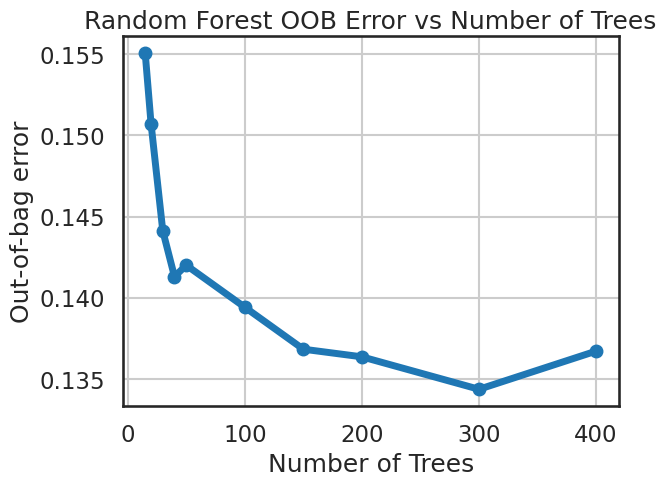

In [ ]:
# Set plot style and context
sns.set_context('talk')
sns.set_style('white')

# Plot OOB error
plt.figure(figsize=(14, 7))
ax = rf_oob_df.plot(legend=False, marker='o', linewidth=5)
ax.set_ylabel('Out-of-bag error')
ax.set_xlabel('Number of Trees')
ax.set_title('Random Forest OOB Error vs Number of Trees')
plt.grid(True)
plt.show()

---

## Part 4: Extra Trees
*Objective:* Train Extra Trees model and compare it to Random Forest.

*Steps & Explanation:*
- *ExtraTreesClassifier:*
  - Like Random Forest, but splits are chosen randomly.
  - Faster and sometimes more generalizable.
- *OOB Comparison:*
  - OOB error is calculated similarly.
  - Results from Extra Trees and Random Forest are plotted side-by-side to compare generalization.

---

In [ ]:
# Initialize Extra Trees Classifier
EF = ExtraTreesClassifier(
    oob_score=True,
    random_state=42,
    warm_start=True,
    bootstrap=True,  # Required for OOB score
    n_jobs=-1
)

et_oob_list = []

# Try different numbers of trees
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]:
    EF.set_params(n_estimators=n_trees)

    # Fit the model using the encoded training data
    EF.fit(X_train_encoded, y_train)

    oob_error = 1 - EF.oob_score_
    et_oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

# Combine into DataFrame
et_oob_df = pd.concat(et_oob_list, axis=1).T.set_index('n_trees')
et_oob_df

,oob
n_trees,
15.0,0.165294
20.0,0.161059
30.0,0.152588
40.0,0.151765
50.0,0.148000
100.0,0.146000
150.0,0.144824
200.0,0.144118
300.0,0.143059


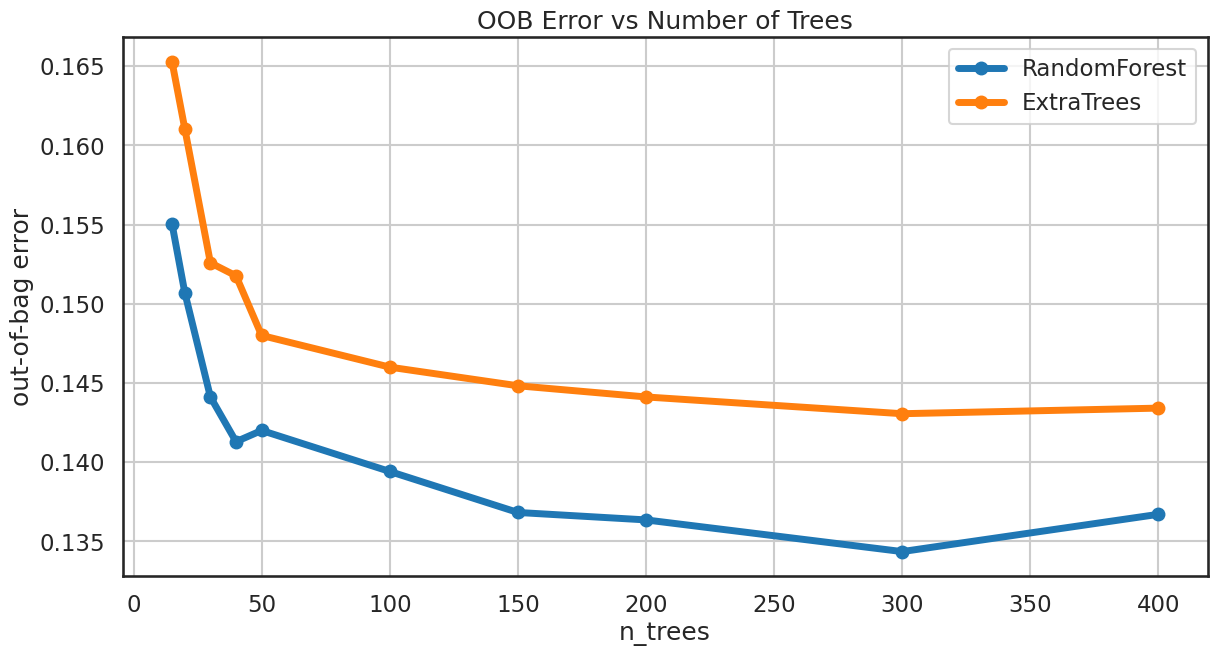

In [ ]:
# Combine both models' OOB errors into one dataframe for plotting
oob_df = pd.concat([
    rf_oob_df.rename(columns={'oob': 'RandomForest'}),
    et_oob_df.rename(columns={'oob': 'ExtraTrees'})
], axis=1)

# Plot OOB errors
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('talk')
sns.set_style('white')

ax = oob_df.plot(marker='o', figsize=(14, 7), linewidth=5)
ax.set_ylabel('out-of-bag error')
ax.set_xlabel('n_trees')
ax.set_title('OOB Error vs Number of Trees')
plt.grid(True)
plt.show()

---

## Part 5: Evaluation
*Objective:* Evaluate model predictions using test data.

*Steps & Explanation:*
- *Model Finalization:* Random Forest with ~100 trees is chosen based on OOB performance.
- *Predictions:*
  - Test set is encoded and fed into the model.
  - classification_report outputs precision, recall, F1-score.
- *Evaluation Metrics:*
  - *Precision:* Correct churn predictions out of all predicted churns.
  - *Recall:* Churns caught out of all actual churns.
  - *F1-score:* Harmonic mean of precision and recall.
  - *ROC-AUC:* Overall discrimination between churn and non-churn.

---

In [ ]:
# Set final model to 100 estimators
model = RF.set_params(n_estimators=100)

# Preprocess test set with same preprocessor used for train
X_test_encoded = preprocessor.transform(X_test)

# Predict on test set
y_pred = model.predict(X_test_encoded)

In [ ]:
# Detailed classification report
cr = classification_report(y_test, y_pred)
print(cr)

# Summary of key metrics
score_df = pd.DataFrame({
    'accuracy': [accuracy_score(y_test, y_pred)],
    'precision': [precision_score(y_test, y_pred)],
    'recall': [recall_score(y_test, y_pred)],
    'f1': [f1_score(y_test, y_pred)],
    'auc': [roc_auc_score(y_test, y_pred)]
})

print(score_df)

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1194
           1       0.71      0.45      0.55       306

    accuracy                           0.85      1500
   macro avg       0.79      0.70      0.73      1500
weighted avg       0.84      0.85      0.84      1500

   accuracy  precision    recall     f1       auc
0  0.849333   0.706186  0.447712  0.548  0.699987


---

## Part 6: Interpretability
*Objective:* Visualize model performance and feature influence.

*Steps & Explanation:*
- *Confusion Matrix:* Normalized matrix shows how well the model performs on both classes.
- *ROC Curve:* Visualizes trade-off between true positive rate and false positive rate.
- *Precision-Recall Curve:* Especially useful when dealing with imbalanced data.
- *Feature Importance Pie Chart:* Shows how much each feature contributes to the prediction—helpful for business decisions (e.g., if “Tenure” is high, focus retention efforts there).

---

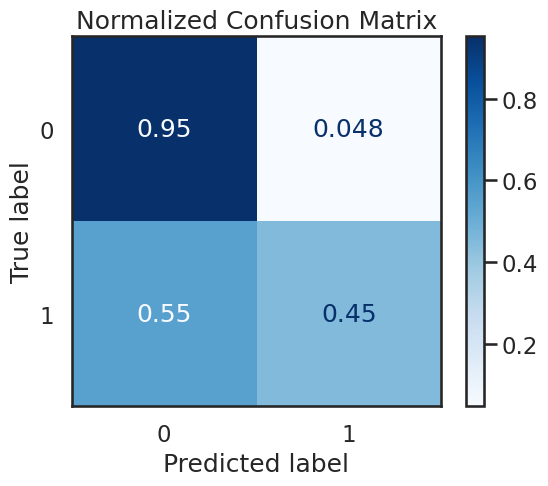

In [ ]:
# 1. Confusion Matrix
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title("Normalized Confusion Matrix")
plt.grid(False)
plt.show()

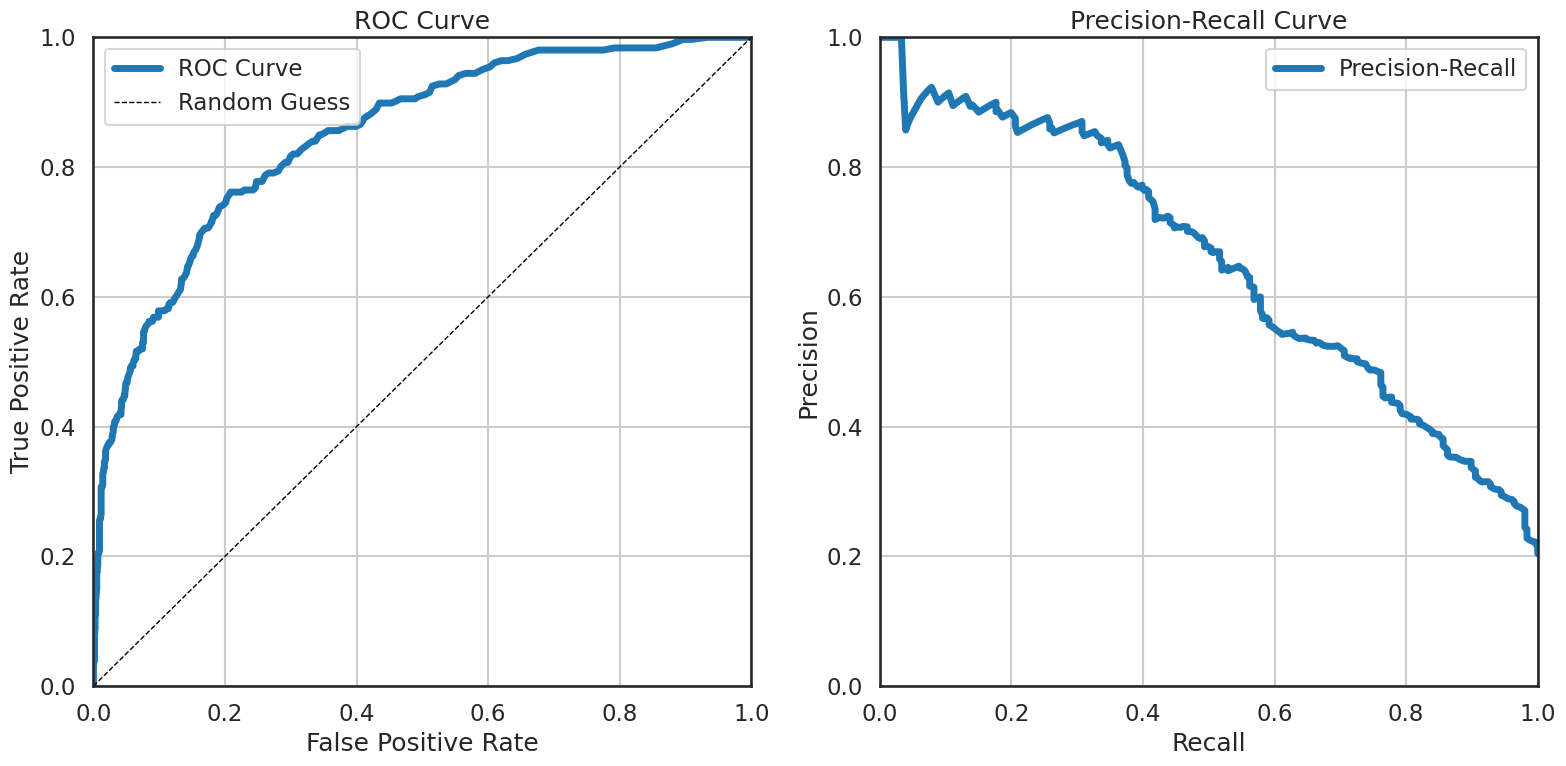

In [ ]:
# 2. ROC-AUC and Precision-Recall Curves
fig, axList = plt.subplots(ncols=2, figsize=(16, 8))

# ROC Curve
y_prob = model.predict_proba(X_test_encoded)
fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
ax = axList[0]
ax.plot(fpr, tpr, linewidth=5, label='ROC Curve')
ax.plot([0, 1], [0, 1], ls='--', color='black', lw=1, label='Random Guess')
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate',
       title='ROC Curve', xlim=[0, 1], ylim=[0, 1])
ax.legend()
ax.grid(True)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob[:, 1])
ax = axList[1]
ax.plot(recall, precision, linewidth=5, label='Precision-Recall')
ax.set(xlabel='Recall', ylabel='Precision',
       title='Precision-Recall Curve', xlim=[0, 1], ylim=[0, 1])
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

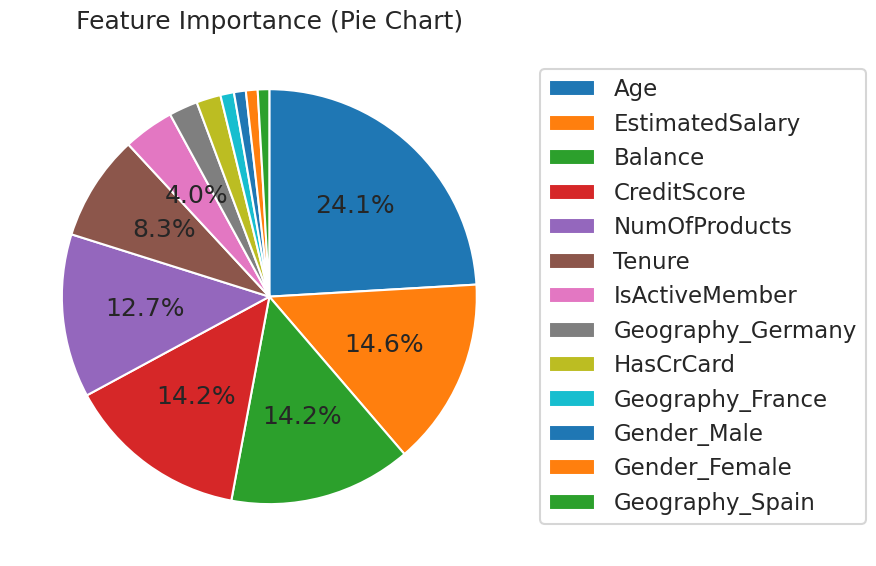

In [ ]:
# 3. Feature Importance Pie Chart
categorical_features = ['Geography', 'Gender']
numerical_features = [col for col in feature_cols if col not in categorical_features]

# Get column names from fitted preprocessor
onehot_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numerical_features, onehot_columns])

# Get feature importances from the model
feature_imp = pd.Series(model.feature_importances_, index=all_feature_names).sort_values(ascending=False)

# Plot pie chart of feature importance
# Plot pie chart of feature importance
fig, ax = plt.subplots(figsize=(12, 6))
wedges, texts, autotexts = ax.pie(
    feature_imp,
    labels=None,
    autopct=lambda pct: f'{pct:.1f}%' if pct > 3 else '',
    startangle=90,
    counterclock=False
)

ax.set_title("Feature Importance (Pie Chart)")
plt.legend(labels=feature_imp.index, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


---

## Part 7: Hyperparameter Tuning
*Objective:* Optimize model parameters using Grid Search.

*Steps & Explanation:*
- *GridSearchCV:*
  - Searches for best combination of hyperparameters.
  - Parameters tuned: number of trees, max depth, min samples split, max features.
- *Cross-Validation:*
  - 5-fold CV ensures model generalizes across splits.
  - Best performing parameters are printed.
- *Top 10 Feature Importances:*
  - Plotted in a bar chart for clearer visual interpretation.

---

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation score: 0.8647058823529413


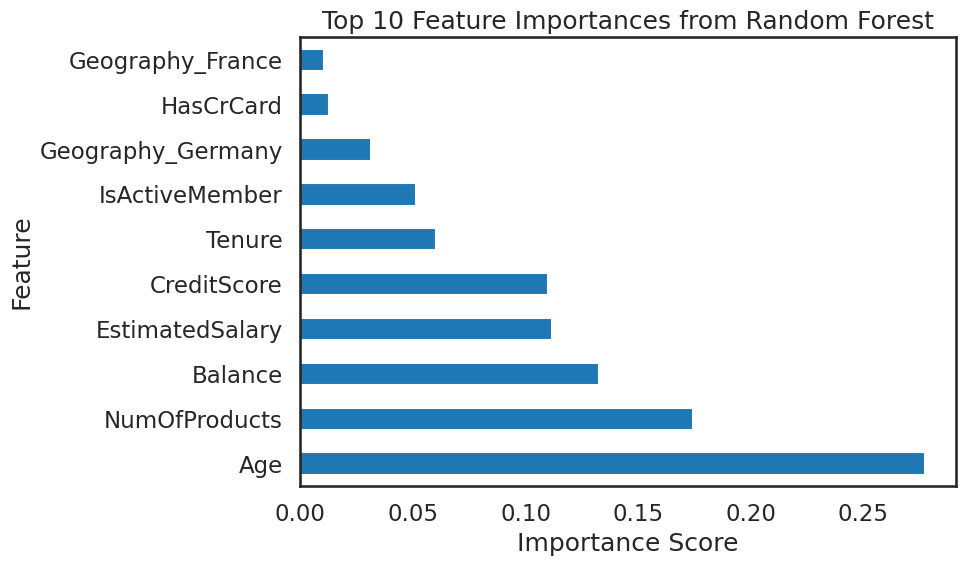

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10]
}

# GridSearch with encoded data
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, oob_score=True),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search.fit(X_train_encoded, y_train)

# Output best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Feature importance with column names
onehot_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
numerical_features = [col for col in feature_cols if col not in categorical_features]
all_feature_names = np.concatenate([numerical_features, onehot_columns])

importances = grid_search.best_estimator_.feature_importances_
feat_importances = pd.Series(importances, index=all_feature_names)

# Plot top 10
feat_importances.nlargest(10).plot(kind='barh', figsize=(10, 6))
plt.title("Top 10 Feature Importances from Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## Part 8: XGBoost Evaluation
*Objective:* Train an alternative ensemble model and compare performance.

*Steps & Explanation:*
- *XGBClassifier:* Gradient boosting model with high performance, often used in competitions.
- *Evaluation:*
  - Same test set is used to evaluate accuracy, recall, F1, and AUC.
- *ROC Comparison:*
  - ROC curves of XGBoost and Random Forest are plotted together.
  - Higher AUC indicates better class separation ability.


Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.91      1194
           1       0.72      0.44      0.55       306

    accuracy                           0.85      1500
   macro avg       0.80      0.70      0.73      1500
weighted avg       0.84      0.85      0.84      1500

Confusion Matrix:
 [[1142   52]
 [ 171  135]]
ROC AUC Score: 0.8527085317655816


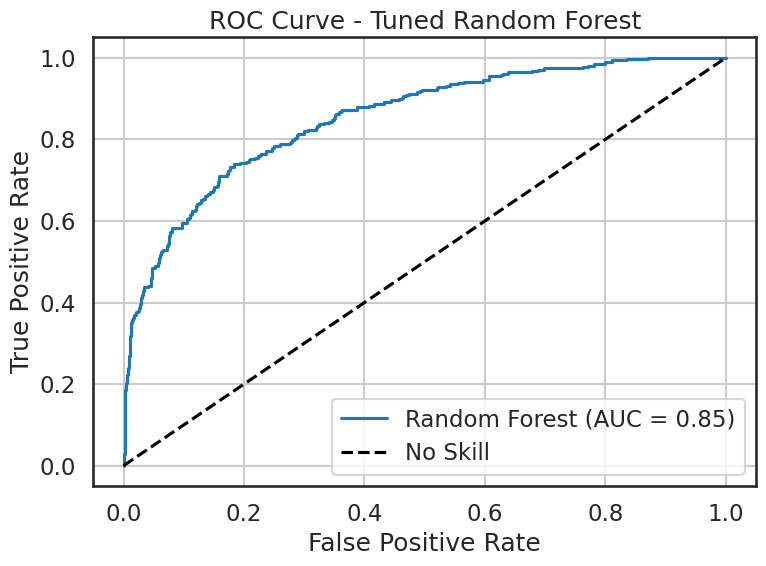

In [ ]:
# Predict with best model
y_pred = grid_search.predict(X_test_encoded)
y_proba = grid_search.predict_proba(X_test_encoded)[:, 1]

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Random Forest (AUC = %0.2f)' % roc_auc_score(y_test, y_proba))
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Tuned Random Forest')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91      1194
           1       0.67      0.49      0.57       306

    accuracy                           0.85      1500
   macro avg       0.77      0.72      0.74      1500
weighted avg       0.84      0.85      0.84      1500

XGBoost Confusion Matrix:
 [[1119   75]
 [ 155  151]]
XGBoost ROC AUC Score: 0.8282945227225452


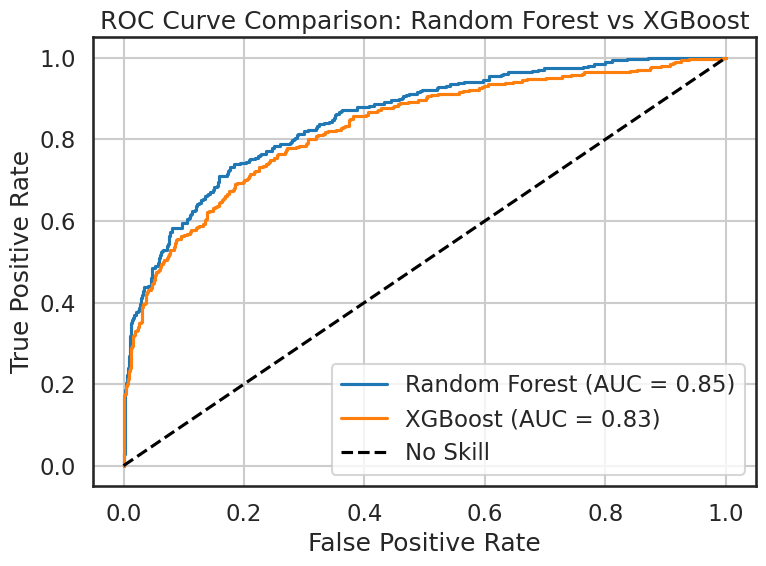

In [ ]:
from xgboost import XGBClassifier

# Fit XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_encoded, y_train)

# Predict
xgb_preds = xgb_model.predict(X_test_encoded)
xgb_proba = xgb_model.predict_proba(X_test_encoded)[:, 1]

# Evaluation
print("XGBoost Classification Report:\n", classification_report(y_test, xgb_preds))
print("XGBoost Confusion Matrix:\n", confusion_matrix(y_test, xgb_preds))
print("XGBoost ROC AUC Score:", roc_auc_score(y_test, xgb_proba))

# Compare ROC Curves
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = %0.2f)' % roc_auc_score(y_test, y_proba))
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost (AUC = %0.2f)' % roc_auc_score(y_test, xgb_proba))
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: Random Forest vs XGBoost')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


##  Final Takeaways

- *Bagging methods like Random Forest gave high accuracy and fast training.*
- *OOB error helped us choose model size without a separate validation set.*
- *Feature importance explained why the model made certain predictions.*
- *Our model is ready to be used by banks to predict and reduce customer churn.*
